# Skin Disease Detection System Using PyTorch (EfficientNetB0 with modifications)

Paper For Reference: https://iopscience.iop.org/article/10.1088/1742-6596/2595/1/012008/pdf

Paper proposes EfficientNetB0 with modifications.


## Importing Data & Basic Setup


In [1]:
# !pip install kagglehub

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shubhamgoel27/dermnet")

# print("Path to dataset files:", path)

In [3]:
path = "Data/Dermnet/VARIANT" # 3 Diseases Only

train_dir = path + "/train"
test_dir = path + "/test"

In [4]:
import torch
import torchvision
from torchvision import transforms
from pathlib import Path
from torch import nn

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.xpu.is_available():
    device = "xpu"
else: device = "cpu"
device

'cpu'

## Transforms, Dataset & Dataloader


In [94]:
from torchvision import transforms

# Data augmentation has shown to reduce overfitting. My aim with these augments is to make the model find patterns V/S rote memorization.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomRotation(degrees=80),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])
test_transfrom = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(train_dir,
                                                 transform=train_transform,
                                                 target_transform=None)

test_dataset = torchvision.datasets.ImageFolder(test_dir,
                                                 transform=test_transfrom,
                                                 target_transform=None)

img, label = train_dataset[1][0], train_dataset[1][1]

img.shape

torch.Size([3, 224, 224])

In [95]:
len(train_dataset)

300

In [96]:
class_names = train_dataset.classes
len(class_names)

3

Text(0.5, 1.0, 'Acne and Rosacea Photos')

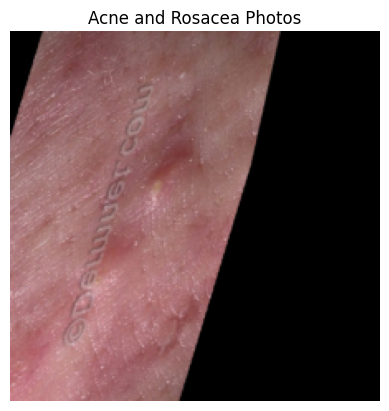

In [97]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [98]:
import os
os.cpu_count()

8

In [99]:
from torch.utils.data import DataLoader

BATCH_SIZE = 50

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=8)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=8)

len(train_dataloader), len(test_dataloader)

(6, 2)

In [100]:
num_classes = len(train_dataset.classes)

## Model


In [101]:
import torch
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import nn
# import "./efficientnetb0_model_ValAcc_44_______direction_good.pth" as weights

model_0 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)

model_0.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
)

model_0 = model_0.to(device)

for param in list(model_0.features.parameters())[:7]:
    param.requires_grad = False

model_0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Custom Functions For Training & Testing


In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from timeit import default_timer as timer

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to be considered an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

def train_step(model: nn.Module,
               dataloader,
               loss_fn,
               optimizer,
               acc_fn,
               device):

    train_acc, train_loss = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        model.train().to(device)
        X, y = X.to(device), y.to(device)
        logits = model(X).to(device)

        y = y.to(torch.int64).to(device)

        loss = loss_fn(logits, y)
        acc = acc_fn(preds=logits.argmax(dim=1), target=y)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            print(f"Went through {batch} batches")
            print(f"|| Train_Accuracy: {acc:.3f} & Train_Loss: {loss:.3f} ||")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"|| Train_Accuracy: {train_acc:.3f} & Train_Loss: {train_loss:.3f} ||")
    print("Training for current epoch completed successfully.")
    return train_acc, train_loss

def test_step(model: nn.Module,
             dataloader,
             loss_fn,
             acc_fn,
             device):

    test_acc, test_loss = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        model.eval()
        X, y = X.to(device), y.to(device)
        with torch.inference_mode():
            logits = model(X).to(device)
            y = y.to(torch.int64)

            loss = loss_fn(logits, y)
            acc = acc_fn(preds=logits.argmax(dim=1), target=y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 2 == 0:
                print(f"Went through {batch} batches")
                print(f"|| Test_Acc: {acc:.3f} & Test_Loss: {loss:.3f} ||")

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"|| Test_Accuracy: {test_acc:.3f} & Test_Loss: {test_loss:.3f} ||")
    print("Testing for current epoch completed successfully.")
    return test_acc, test_loss

def train(model: nn.Module,
        train_dataloader,
        test_dataloader,
        loss_fn,
        optimizer,
        acc_fn,
        device,
        epochs: int):
    """
    Function to train the model for a specified number of epochs
    """

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        start = timer()
        print(f"\n\nStarting Epoch: {epoch}-----------------------------")
        train_acc, train_loss = train_step(model, train_dataloader, loss_fn, optimizer, acc_fn, device)
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)
        print(f"\nEnding Epoch: {epoch}-----------------------------")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Early stopping check
        early_stopping(test_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        end = timer()
        print(f"Time Taken For Current Epoch: {end-start:.2f} seconds")
    
    return results


In [103]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=1e-2,
                            momentum=0.9)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

## Training Loop


In [ ]:
from timeit import default_timer as timer

start = timer()

EPOCHS = 120

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        acc_fn=acc_fn,
                        device=device,
                        epochs=EPOCHS)

end = timer()

print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

In [34]:
model_0_results

{'train_loss': [0.8933693567911783,
  0.6518859068552653,
  0.552681028842926,
  0.3735883980989456,
  0.29898427923520404,
  0.22421555469433466,
  0.16987821087241173,
  0.12293184796969096,
  0.09553166354695956,
  0.06594591587781906,
  0.06501277939726909,
  0.053101523158450924,
  0.03317992016673088,
  0.04230744546900193,
  0.036908602342009544,
  0.04285253196333846,
  0.04617113138859471,
  0.02689998286465804,
  0.043547684947649636,
  0.0169716061403354,
  0.026478508875394862,
  0.021314992103725672,
  0.020929339303014178,
  0.01813417944746713,
  0.021704479586333036,
  0.02108723670244217,
  0.014419587794691324,
  0.013836912577971816,
  0.018344919856948156,
  0.028732140626137454,
  0.009719512929829458,
  0.012563924654386938,
  0.01818339026067406,
  0.01593510783277452,
  0.009179555733377734,
  0.009640626958571374,
  0.03027226069631676,
  0.006543997733388096,
  0.008210880953508118,
  0.01179444855855157,
  0.01126979555313786,
  0.015021446102764457,
  0.0133

In [39]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

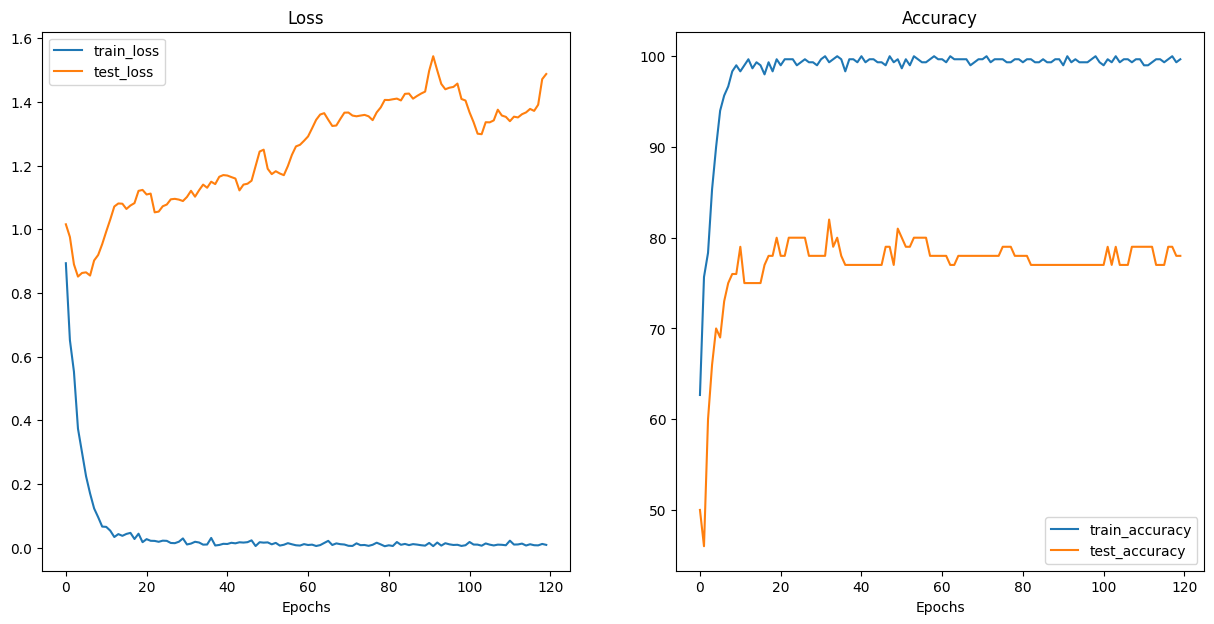

In [40]:
plot_loss_curves(model_0_results)

In [45]:
from pathlib import Path

model_path = Path("./models")
path = model_path / "EfficientNetB0___Overfitting_again.pth"

model_path.mkdir(
    parents=True,
    exist_ok=True
)

torch.save(obj=model_0,
           f=path)

print("Save Success")

Save Success


## Resnet34

In [57]:
model_1 = torch.load(f="./models/model_ResNet34.pth", weights_only=False)

In [92]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=1e-2,
                            momentum=0.9,
                            weight_decay=0.0001)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

In [105]:
from timeit import default_timer as timer

start = timer()

EPOCHS = 200

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        acc_fn=acc_fn,
                        device=device,
                        epochs=EPOCHS)

end = timer()

print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

  0%|          | 0/200 [00:00<?, ?it/s]



Starting Epoch: 0-----------------------------
Went through 0 batches
|| Train_Accuracy: 84.000 & Train_Loss: 0.437 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.657 ||
Went through 4 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.644 ||
|| Train_Accuracy: 80.667 & Train_Loss: 0.585 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 86.000 & Test_Loss: 0.578 ||


  0%|          | 0/200 [01:05<?, ?it/s]

|| Test_Accuracy: 75.000 & Test_Loss: 0.877 ||
Testing for current epoch completed successfully.

Ending Epoch: 0-----------------------------
Early stopping triggered
Training Time: 65.53 seconds for 200 epochs on cpu.


In [77]:
test_step(model=model_1,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          acc_fn=acc_fn,
          device=device)

Went through 0 batches
|| Test_Acc: 82.000 & Test_Loss: 0.748 ||
|| Test_Accuracy: 77.000 & Test_Loss: 0.836 ||
Testing for current epoch completed successfully.


(77.0, 0.8356891870498657)

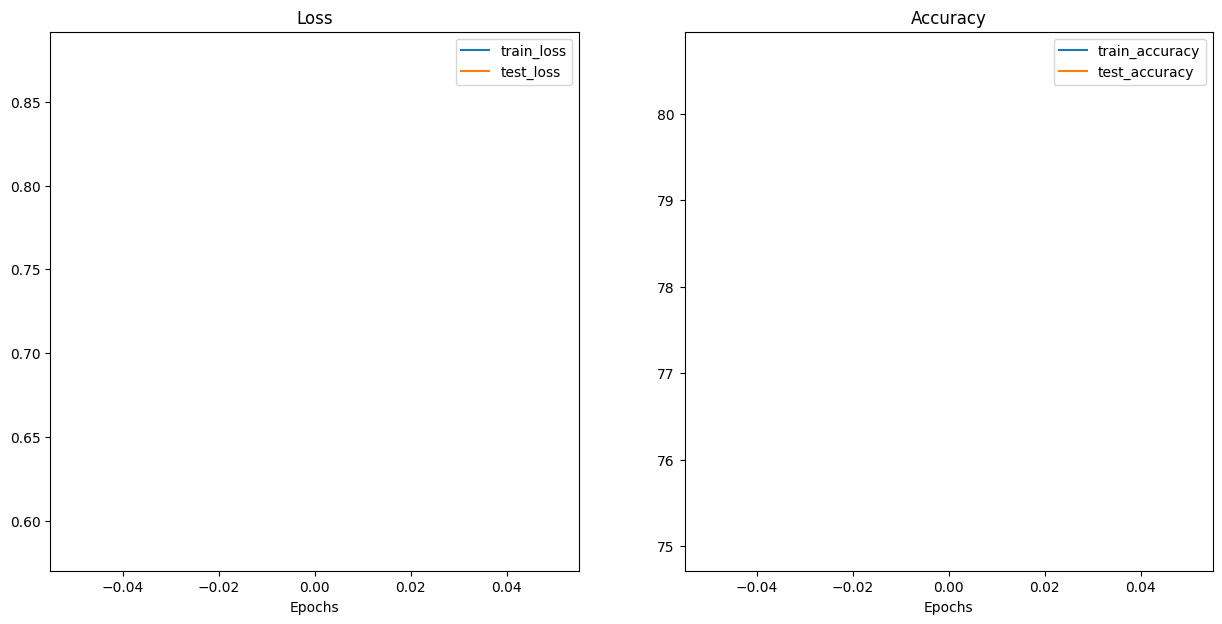

In [106]:
plot_loss_curves(model_1_results) # This is the resnet model @25 epochs

In [107]:
from pathlib import Path

model_path = Path("./models")
path = model_path / "ResNet34____Best_till_now.pth"

model_path.mkdir(
    parents=True,
    exist_ok=True
)

torch.save(obj=model_1,
           f=path)

print("Save Success")

Save Success


In [110]:
t = torch.load(f="./models/ResNet34____Best_till_now.pth", weights_only=False)
test_step(model=t,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          acc_fn=acc_fn,
          device=device)

Went through 0 batches
|| Test_Acc: 86.000 & Test_Loss: 0.578 ||
|| Test_Accuracy: 75.000 & Test_Loss: 0.877 ||
Testing for current epoch completed successfully.


(75.0, 0.8771964013576508)